In [31]:
import pandas as pd
import requests
import os
import tweepy
import json
from timeit import default_timer as timer
import numpy as np
import re
import matplotlib.pyplot as plt

## Gather
#### 1-file at hand

In [32]:
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### 2- image predictions

In [33]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image-predictions.tsv',mode ='wb') as file:
    file.write(r.content)

In [34]:
df_2 = pd.read_csv('image-predictions.tsv',sep = '\t')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


####  3- tweepy API

#Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
#These are hidden to comply with Twitter's API terms and conditions

In [35]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

#### NOTE TO REVIEWER: this student had mobile verification issues so the following
#### Twitter API code was sent to this student from a Udacity instructor
#### Tweet IDs for which to gather additional data via Twitter's API

In [36]:
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

2356

#### i changed this cell to markdown so it wont affect the code flow
##### Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
##### Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [37]:
tweets = []
for line in open('tweet_json.txt', 'r'):
    tweets.append(json.loads(line))
df_3 = pd.DataFrame.from_dict(tweets)

In [38]:
df_3 = df_3[['id_str','retweet_count','favorite_count']]

# Assess
## Quality

### in twitter archive enhanced
- name column contians 'a' instead of an actual name 
- timestamp,retweet_status_timestamp should be of type datetime 
- None in Doggo,floofer,pupper,puppo columns should be changed to NANs 
- tweet_id should be object
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be object datatype
### in image_predictions
- inconsistency as in jpg_urls there are png file df_2[320]
- tweet_id should be object
- column names are not  illustrative 
### in api scraped dataframe 
- id_str should be tweet_id to be consistent with other tables if we want to join them later
--------------------------------------

# tidiness

- Doggo,floofer,pupper,puppo should be melted into one column
- text column contains both link and text which breaks first rule of tidiness
- df_1, df_2 and df_3 should be merged into 1 dataset

# Clean
## Quality Issues (missing data)

In [39]:
df_1_copy = df_1.copy()
df_2_copy = df_2.copy()
df_3_copy = df_3.copy()

### Define

- convert all 'a' entries to NANs 
- #####None should be changed to NANs

### Code

In [40]:
df_1_copy['name'].replace("a", np.nan, inplace = True)
df_1_copy.replace('None','', inplace = True)

### Test

In [41]:
df_1_copy['name'].value_counts()
df_1_copy['doggo'].value_counts()

         2259
doggo      97
Name: doggo, dtype: int64

## Tidiness

### Define

 - remove link from text column and add it in seperate column using regular expression 

### Code

In [42]:
#extract link from text and put it in seperate column
df_1_copy['direct_link'] = df_1_copy.text.str.extract('(?P<url>https?://[^\s]+)')

#remove link from text column
counter = 1
print('processing')
for text in df_1_copy.text:
    print(counter)
    df_1_copy.text[counter] = re.sub('(?P<url>https?://[^\s]+)','',text)
    counter += 1

processing
1
2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


### Test

In [43]:
df_1_copy.text[15]

"This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek "

### Define

- convert Doggo,floofer,pupper,puppo into one column 

### Code

In [44]:
#combine the columns to get either an empty string or 1 dog type or multiple dog types
df_1_copy['dog_type'] = df_1_copy.doggo+df_1_copy.floofer+df_1_copy.pupper+df_1_copy.puppo

#drop Doggo,floofer,pupper,puppo columns 
df_1_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'],axis = 1, inplace = True)

In [45]:
#seperate dogtypes
df_1_copy.loc[df_1_copy.dog_type == 'doggopupper', 'dog_type'] = 'doggo,pupper'
df_1_copy.loc[df_1_copy.dog_type == 'doggopuppo', 'dog_type'] = 'doggo,puppo'
df_1_copy.loc[df_1_copy.dog_type == 'doggofloofer', 'dog_type'] = 'doggo,floofer'

### Test

In [46]:
df_1_copy.dog_type.value_counts()

                 1976
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: dog_type, dtype: int64

### Define
- these are quality issue that needs to get handled before merging 
 (  change id_str to tweet_id, change tweets_id type to object )
- merge df_1 and df_3 

### Code

In [47]:
df_3_copy.rename(columns = {'id_str':'tweet_id'},inplace = True)
df_1_copy['tweet_id'] = df_1_copy['tweet_id'].astype(str)
df_2_copy['tweet_id'] = df_2_copy['tweet_id'].astype(str)

In [48]:
df_merged = pd.merge(df_1_copy,df_2_copy,how = 'left', on = ['tweet_id'])
df_merged = pd.merge(df_merged,df_3_copy,how = 'left', on = ['tweet_id'])

### Test

In [49]:
df_merged.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'direct_link', 'dog_type', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

#### Lets get back to Quality issues after we finished tidiness issues

### Define

## in image_predictions
- inconsistency as in jpg_urls there are png file df_2[320]
- tweet_id should be object
- column names are not  illustrative

### Code


In [50]:
###rename columns
df_merged.rename(columns = {'p1':'first_prediction','p1_conf':'prediction1_confidence','p1_dog':'prediction1_dog',
                            'p2':'second_prediction','p2_conf':'prediction2_confidence','p2dog':'prediction2_dog',
                            'p3':'third_prediction','p3_conf':'prediction3_confidence','p3dog':'prediction3_dog'})

###  change png file df_2[320] to jpg
link = df_merged.jpg_url[320].replace('png','jpg')
df_merged.jpg_url[320] = link

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Test

In [51]:
df_merged.info()
df_merged.jpg_url[320]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2301 non-null object
direct_link                   2265 non-null object
dog_type                      2356 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
p1                            

'https://pbs.twimg.com/media/C5SXK89XUAQg7GX.jpg'

## Define
### in df_merged
- timestamp,retweet_status_timestamp convert to type datetime 
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id convert to object datatype
- retweet_count and favorite_count convert to int
- chnage empty values to NANs
- p1_dog, p2_dog, p3_dog to bool

### Code

In [52]:
## chnage empty values to NANs
df_merged.replace('',np.nan, inplace = True)

## change datatypes
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp']) 
df_merged['retweeted_status_timestamp'] = pd.to_datetime(df_merged['retweeted_status_timestamp']) 
df_merged['in_reply_to_status_id'] = df_merged['in_reply_to_status_id'].astype(str)
df_merged['retweeted_status_id'] = df_merged['retweeted_status_id'].astype(str)
df_merged['in_reply_to_user_id'] = df_merged['in_reply_to_user_id'].astype(str)
df_merged['retweeted_status_user_id'] = df_merged['retweeted_status_user_id'].astype(str)

## retweet_count and favorite_count convert to int
df_merged['retweet_count'] = df_merged['retweet_count'].fillna(0).astype(int)
df_merged['favorite_count'] = df_merged['favorite_count'].fillna(0).astype(int)

## p1_dog, p2_dog, p3_dog to bool
df_merged['p1_dog'] = df_merged['p1_dog'].astype(bool)
df_merged['p2_dog'] = df_merged['p2_dog'].astype(bool)
df_merged['p3_dog'] = df_merged['p3_dog'].astype(bool)

### Test

In [53]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1556 non-null object
direct_link                   2265 non-null object
dog_type                      380 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
p1           

# STORE

In [54]:
df_merged.to_csv('twitter_archive_master.csv',index = False)

### Analyzing, and Visualizing Data for this Project

In [55]:
df_merged.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
560,802952499103731712,nan,nan,2016-11-27 19:09:28,"<a href=""http://twitter.com/download/iphone"" r...",This is Winston. His selfie game is legendary....,nan,nan,NaT,https://twitter.com/dog_rates/status/802952499...,...,0.944032,True,golden_retriever,0.017240,True,Pomeranian,0.012085,True,2336,10085
1744,679158373988876288,nan,nan,2015-12-22 04:35:49,"<a href=""http://twitter.com/download/iphone"" r...",Crazy unseen footage from Jurassic Park. 10/10...,nan,nan,NaT,https://twitter.com/dog_rates/status/679158373...,...,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False,9193,23568
353,831309418084069378,nan,nan,2017-02-14 01:09:44,"<a href=""http://twitter.com/download/iphone"" r...",I couldn't make it to the #WKCDogShow BUT I ha...,nan,nan,NaT,https://twitter.com/dog_rates/status/831309418...,...,0.369389,True,kelpie,0.132449,True,Labrador_retriever,0.074727,True,2786,12819
1392,700062718104104960,nan,nan,2016-02-17 21:02:13,"<a href=""http://twitter.com/download/iphone"" r...",When it's Janet from accounting's birthday but...,nan,nan,NaT,https://twitter.com/dog_rates/status/700062718...,...,0.180998,False,peacock,0.135179,False,eel,0.075371,False,778,2890
1798,677228873407442944,nan,nan,2015-12-16 20:48:40,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest pupper I've ever seen. 10...,nan,nan,NaT,https://twitter.com/dog_rates/status/677228873...,...,0.566338,False,tennis_ball,0.154646,False,green_lizard,0.044976,False,1840,3837
2078,670832455012716544,nan,nan,2015-11-29 05:11:35,"<a href=""http://twitter.com/download/iphone"" r...",This is Jett. He is unimpressed by flower. 7/10,nan,nan,NaT,https://twitter.com/dog_rates/status/670832455...,...,0.317607,True,Norwegian_elkhound,0.274901,True,bathing_cap,0.114643,False,242,780
1208,715704790270025728,nan,nan,2016-04-01 00:58:13,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is a taco. We only rate dogs. Please only...,nan,nan,NaT,https://vine.co/v/ijAlDnuOD0l,...,NaN,True,NaN,NaN,True,NaN,NaN,True,634,3055
1654,683449695444799489,nan,nan,2016-01-03 00:47:59,"<a href=""http://twitter.com/download/iphone"" r...","""Hello forest pupper I am house pupper welcome...",nan,nan,NaT,https://twitter.com/dog_rates/status/683449695...,...,0.303512,True,soft-coated_wheaten_terrier,0.211424,True,golden_retriever,0.170725,True,1837,4290
1189,718246886998687744,nan,nan,2016-04-08 01:19:36,"<a href=""http://twitter.com/download/iphone"" r...",This pic is old but I hadn't seen it until tod...,nan,nan,NaT,https://twitter.com/dog_rates/status/718246886...,...,0.354488,True,carton,0.159672,False,Siberian_husky,0.057498,True,565,2115
319,834477809192075265,nan,nan,2017-02-22 18:59:48,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo fully pupared for a shower. H*c...,8.29501995191e+17,4196983835.0,2017-02-09 01:27:41,https://twitter.com/dog_rates/status/829501995...,...,NaN,True,NaN,NaN,True,NaN,NaN,True,12224,0


In [56]:
# most favorited tweet
df_merged.favorite_count.max()
df_merged.query('favorite_count == 132810')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
413,822872901745569793,nan,nan,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Albus. He's soaked as h*ck. Seems to h...,nan,nan,NaT,https://twitter.com/dog_rates/status/822872901...,...,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,48265,132810


In [57]:
# most retweeted tweet
df_merged.retweet_count.max()
df_merged.query('retweet_count == 79515')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1039,744234799360020481,nan,nan,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",This is Blanket. She has overthrown her human....,nan,nan,NaT,https://twitter.com/dog_rates/status/744234799...,...,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,79515,131075


In [58]:
#highest rating_numerator
df_merged.query('rating_numerator == 1776') 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
979,749981277374128128,nan,nan,2016-07-04 15:00:45,"<a href=""https://about.twitter.com/products/tw...",This is Bo. He emanates happiness. 12/10 I cou...,nan,nan,NaT,https://twitter.com/dog_rates/status/749981277...,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,2772,5569


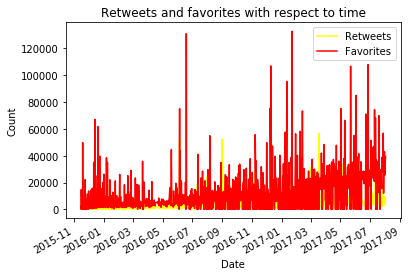

In [59]:
% matplotlib inline 
df_merged.set_index('timestamp', inplace=True)
df_merged['retweet_count'].plot(color = 'yellow', label='Retweets',kind = 'line')
df_merged['favorite_count'].plot(color = 'red', label='Favorites',kind = 'line')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Retweets and favorites with respect to time')
plt.legend()
plt.show()